In [1]:
cd ..


/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier


In [2]:
from src.d04_mixmatch.wideresnet import WideResNet
from src.d02_data.load_data import get_dataloaders_validation, get_dataloaders_ssl
from src.d03_processing.transform_data import AddGaussianNoise, Augment
from src.d07_visualization.visualize_cifar10 import show_img
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


Files already downloaded and verified
Files already downloaded and verified


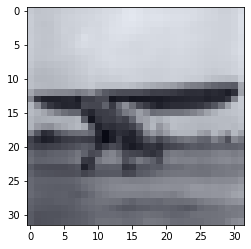

tensor(0)


In [5]:
# Get data
train_loader, unlbl_loader, val_loader, test_loader, _, _, _ = get_dataloaders_ssl(path='data', batch_size=64, num_labeled=250, which_dataset='cifar10')
iterator = iter(train_loader).next()
show_img(iterator[0][0])
print(iterator[1][0])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


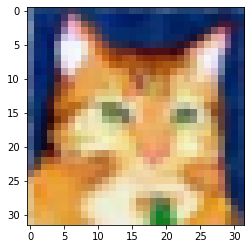

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


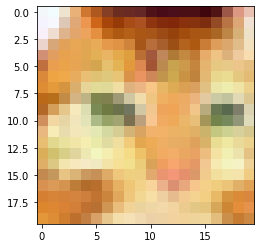

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


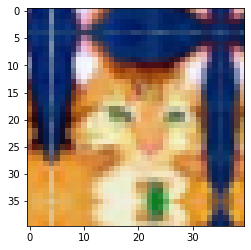

In [6]:
import torchvision.transforms as tf
crop = tf.CenterCrop(20)

img = iter(train_loader).next()[0][0]
show_img(img)
croped_img = crop(img)
show_img(croped_img)

border=4
img_pad = np.pad(img, [(0, 0), (border, border), (border, border)], mode='reflect')
show_img(torch.Tensor(img_pad))

In [71]:
class RandomCrop(torch.nn.Module):
    """
    1- Pad an image with reflection a random number of pixels in each side
    2- Crop the same number of pixels, in random side
    Returns an image of the same input size
    """
    def __init__(self, max_crop):
        super().__init__()
        self.max_crop = max_crop

    def forward(self, img):
        img = img.cpu().numpy()
        h, w = img.shape[2:]
        crop_size = np.random.randint(1, self.max_crop)
        imgaux = np.pad(img, [(0, 0), (0, 0), (crop_size, crop_size), (crop_size, crop_size)], mode='reflect')
        
        for i in range(img.shape[0]):
            top = np.random.randint(0, crop_size*2)
            print(top)
            left = np.random.randint(0, crop_size*2)

            img[i] = imgaux[i,:, top: top + h, left: left + w]
        return torch.from_numpy(img)

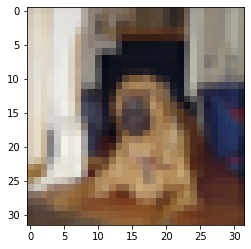

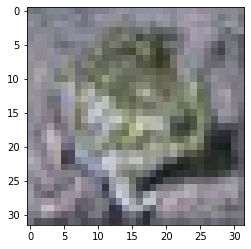

5
3


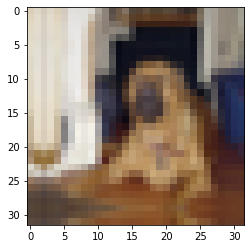

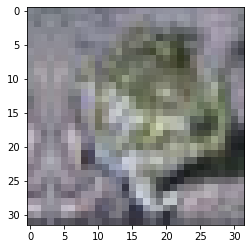

In [73]:
rc = RandomCrop(5)
img = iter(train_loader).next()[0][0:2]
show_img(img[0])
show_img(img[1])

cimg = rc(img)
show_img(cimg[0])
show_img(cimg[1])


In [14]:
# Init new model
model = WideResNet(depth=28, k=2, n_out=10)


In [13]:
# Load saved model
model_name = 'model_fs_adam.pt'
saved_model = torch.load(f'models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10)
model.load_state_dict(saved_model['model_state_dict'])

FileNotFoundError: [Errno 2] No such file or directory: 'models/saved_models/model_fs_adam.pt'

In [15]:
class MixMatch(object):

    def __init__(self, model, batch_size, device='cpu', T=0.5, K=2, alpha=0.75):
        self.T = T
        self.K = K
        self.batch_size = batch_size
        self.alpha = alpha
        self.softmax = nn.Softmax(dim=1)
        self.model = model
        self.device = device
        self.n_labels = 10  # Warning! hardcoded
        self.beta = torch.distributions.beta.Beta(alpha, alpha)

    def run(self, x_imgs, x_labels, u_imgs):
        # One hot encoding
        x_labels = self.one_hot_encoding(x_labels)
        x_labels.to(self.device)

        # Augment
        augment_once = Augment(K=1)
        augment_k = Augment(K=self.K)

        x_hat = augment_once(x_imgs)  # shape (1, batch_size, 3, 32, 32)
        u_hat = augment_k(u_imgs)     # shape (K, batch_size, 3, 32, 32)

        # Generate guessed labels
        q_bar = self.guess_label(u_hat)
        q = self.sharpen(q_bar)  # shape (K, batch_size, 10)

        x_hat = x_hat.reshape((-1, 3, 32, 32))  # shape (batch_size, 3, 32, 32)
        u_hat = u_hat.reshape((-1, 3, 32, 32))  # shape (K*batch_size, 3, 32, 32)
        q = q.repeat(self.K, 1, 1).reshape(-1, 10)  # shape (K*batch_size, 10)

        # Concat and shuffle
        w_imgs = torch.cat((x_hat, u_hat))
        w_labels = torch.cat((x_labels, q))
        w_imgs, w_labels = self.shuffle_matrices(w_imgs, w_labels)

        # Apply MixUp
        x_prime, p_prime = self.mixup(x_hat, w_imgs[:self.batch_size], x_labels, w_labels[:self.batch_size])
        u_prime, q_prime = self.mixup(u_hat, w_imgs[self.batch_size:], q, w_labels[self.batch_size:])

        return (x_prime, p_prime), (u_prime, q_prime)

    def mixup(self, x1, x2, p1, p2):
        n_samples = x1.shape[0]
        lambda_rand = self.beta.sample([n_samples, 1, 1, 1]).to(self.device)  # one lambda per sample
        lambda_prime = torch.max(lambda_rand, 1 - lambda_rand).to(self.device)
        x_prime = lambda_prime * x1 + (1 - lambda_prime) * x2
        lambda_prime = lambda_prime.reshape(-1, 1)
        p_prime = lambda_prime * p1 + (1 - lambda_prime) * p2
        return x_prime, p_prime

    def sharpen(self, q_bar):
        #q_bar = q_bar.numpy()
        q = torch.pow(q_bar, 1 / self.T) / torch.sum(torch.pow(q_bar, 1 / self.T), axis=1)[:, np.newaxis]
        return q
    
    def sharpen2(self, q_bar):
        qt = q_bar**(1/self.T)
        q = qt / qt.sum(dim=1, keepdim=True)
        return q

    def guess_label(self, u_hat):
        self.model.eval()
        with torch.no_grad():
            q_bar = torch.zeros([self.batch_size, self.n_labels], device=self.device)
            for k in range(self.K):
                q_bar += self.softmax(self.model(u_hat[k]))
            q_bar /= self.K

        self.model.train()
        return q_bar

    def one_hot_encoding(self, labels):
        shape = (labels.shape[0], self.n_labels)
        one_hot = torch.zeros(shape, dtype=torch.float32, device=self.device)
        rows = torch.arange(labels.shape[0])
        one_hot[rows, labels] = 1
        return one_hot

    # shuffles along the first axis (axis 0)
    def shuffle_matrices(self, m1, m2):
        n_samples = m1.shape[0]
        rand_indexes = torch.randperm(n_samples)
        m1 = m1[rand_indexes]
        m2 = m2[rand_indexes]
        return m1, m2

In [16]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

In [17]:
mixmatch = MixMatch(model, 64)
x, u = mixmatch.run(x_imgs, x_labels, u_imgs)
loss_mixmatch = Loss(75, 16000)


x_prime = x[0]
p_prime = x[1]
u_prime = u[0]
q_prime = u[1]


loss, lx, lu_w = loss_mixmatch(x_prime, p_prime, u_prime, q_prime, 16000)
print('Loss: ' + str(loss))
print('Lx: ' + str(lx))
print('Lu_w: ' + str(lu_w))


NameError: name 'Loss' is not defined

In [ ]:
[ -6.5369, -11.0531,  -1.4134,  -2.8703,  -0.3930,  -3.9002,  -6.8887,
         -6.1457,  -9.5587, -11.3256]

In [18]:
show_img(x_in[0])
x_out = torch.softmax(x_out, dim=1)
print(x_out[0])
print(x_lbl[0])

ce_loss = - torch.log(torch.mean(torch.sum(x_lbl[0] * x_out[0])))
print(ce_loss.item())

NameError: name 'x_in' is not defined

In [19]:
x_imgs, x_labels = iter(train_loader).next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


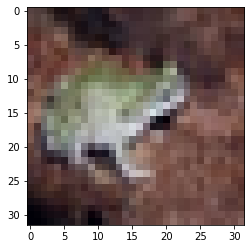

tensor(6)


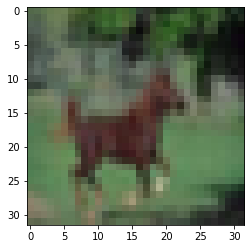

tensor(7)


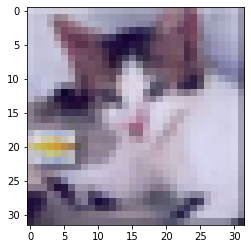

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


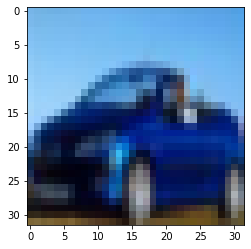

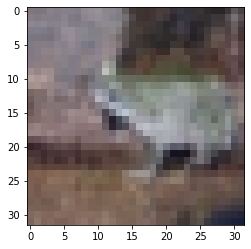

tensor([0.0465, 0.0390, 0.0415, 0.0425, 0.0474, 0.0419, 0.6275, 0.0399, 0.0412,
        0.0326])


In [29]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

show_img(x_imgs[0])
print(x_labels[0])
show_img(x_imgs[1])
print(x_labels[1])
show_img(u_imgs[0])
show_img(u_imgs[1])

model = WideResNet(depth=28, k=2, n_out=10)
mixmatch = MixMatch(model, 64, K=2)
x, u = mixmatch.run(x_imgs, x_labels, u_imgs)


x_prime = x[0]
p_prime = x[1]
u_prime = u[0]
q_prime = u[1]

show_img(x_prime[0])
print(p_prime[0])




In [27]:
x_imgs, x_labels = iter(train_loader).next()


In [12]:
class Loss(object):

    def __init__(self, lambda_u_max, step_top_up):
        self.lambda_u_max = lambda_u_max
        self.step_top_up = step_top_up

    def __call__(self, x_output, x_target, u_output, u_target, step):
        lambda_u = self.ramp_up_lambda(step)
        mse_loss = nn.MSELoss()
        u_output = torch.softmax(u_output, dim=1)
        
        lx = - torch.mean(torch.sum(x_target * torch.log_softmax(x_output, dim=1), dim=1))
        lu = mse_loss(u_output, u_target)
        lu2 = torch.mean((probs_u - targets_u)**2)
        print(lu)
        print(lu2)
        
        loss = lx + lu * lambda_u

        return loss.item(), lx.item(), (lu * lambda_u).item()

    def ramp_up_lambda(self, step):
        if step > self.step_top_up:
            return self.lambda_u_max
        else:
            return self.lambda_u_max * step / self.step_top_up
